In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


In [3]:
!unzip 3100.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: 3100/train/Species6/00184.jpg  
  inflating: 3100/train/Species6/00185.jpg  
  inflating: 3100/train/Species6/00186.jpg  
  inflating: 3100/train/Species6/00190.jpg  
  inflating: 3100/train/Species6/00191.jpg  
  inflating: 3100/train/Species6/00192.jpg  
  inflating: 3100/train/Species6/00193.jpg  
  inflating: 3100/train/Species6/00194.jpg  
  inflating: 3100/train/Species6/00195.jpg  
  inflating: 3100/train/Species6/00196.jpg  
  inflating: 3100/train/Species6/00197.jpg  
  inflating: 3100/train/Species6/00198.jpg  
  inflating: 3100/train/Species6/00200.jpg  
  inflating: 3100/train/Species6/00201.jpg  
  inflating: 3100/train/Species6/00204.jpg  
  inflating: 3100/train/Species6/00205.jpg  
  inflating: 3100/train/Species6/00207.jpg  
  inflating: 3100/train/Species6/00208.jpg  
  inflating: 3100/train/Species6/00210.jpg  
  inflating: 3100/train/Species6/00211.jpg  
  inflating: 3100/train/Species6/00213.jpg  
  inf

In [4]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
# Dataset folders 
dataset_dir = '3100'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

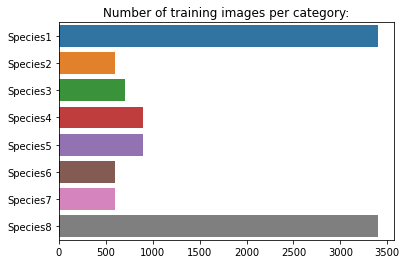

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [8]:
# Used to adopt the cutout augmentation 
def apply_mask(image, size=36, n_squares=1):
    h, w, channels = image.shape
    new_image = image
    for _ in range(n_squares):
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - size // 2, 0, h)
        y2 = np.clip(y + size // 2, 0, h)
        x1 = np.clip(x - size // 2, 0, w)
        x2 = np.clip(x + size // 2, 0, w)
        new_image[y1:y2,x1:x2,:] = 0
    return new_image

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        #zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='constant',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [11]:
# Applay cutout to each train image
for foldername in os.listdir("3100/train/"):
  folder = os.path.join("3100/train/", foldername)
  for filename in os.listdir(folder):
    file = os.path.join(folder, filename)
    image = load_img(file)
    x=img_to_array(image)
    i = 0
    while i <= 3:
      y = apply_mask(x)
      z = array_to_img(y)
      z.save(folder+"/cut_"+str(i)+"_"+filename)
      i+=1

In [12]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 79396 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [13]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0.]
Label: 0
Class name: Species1


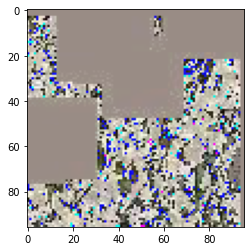

In [14]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [15]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Vgg16')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

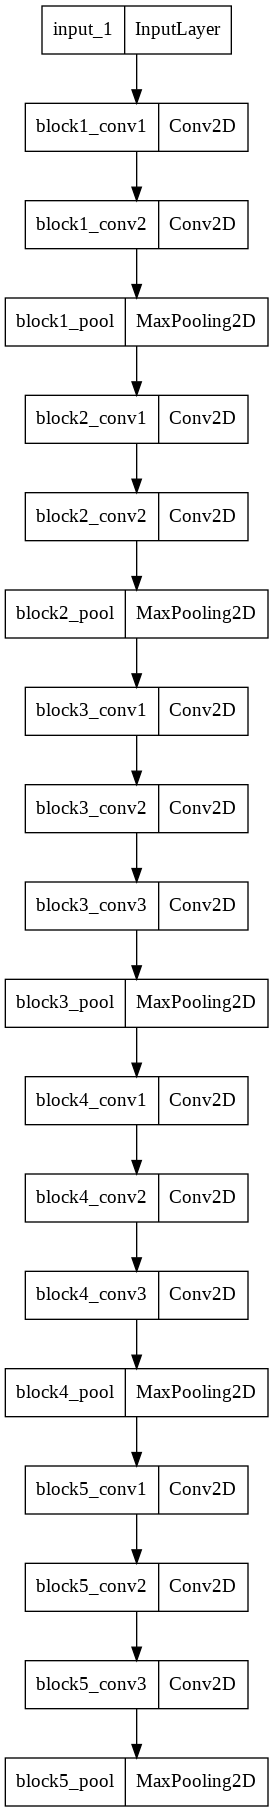

In [ ]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [16]:
input_shape = (96, 96, 3)
epochs = 200

In [ ]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

In [ ]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'model_cutout')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
1266/1266 [==============================] - ETA: 0s - loss: 1.8983 - accuracy: 0.3662 - precision: 0.5250 - recall: 0.1606

1266/1266 [==============================] - 188s 140ms/step - loss: 1.8983 - accuracy: 0.3662 - precision: 0.5250 - recall: 0.1606 - val_loss: 1.3230 - val_accuracy: 0.4516 - val_precision: 0.6900 - val_recall: 0.2998
Epoch 2/200
1266/1266 [==============================] - ETA: 0s - loss: 1.3890 - accuracy: 0.4410 - precision: 0.6355 - recall: 0.2304

1266/1266 [==============================] - 168s 133ms/step - loss: 1.3890 - accuracy: 0.4410 - precision: 0.6355 - recall: 0.2304 - val_loss: 1.2003 - val_accuracy: 0.5256 - val_precision: 0.7674 - val_recall: 0.3757
Epoch 3/200
1266/1266 [==============================] - ETA: 0s - loss: 1.3317 - accuracy: 0.4727 - precision: 0.6531 - recall: 0.2675

1266/1266 [==============================] - 170s 134ms/step - loss: 1.3317 - accuracy: 0.4727 - precision: 0.6531 - recall: 0.2675 - val_loss: 1.1876 - val_accuracy: 0.4877 - val_precision: 0.7377 - val_recall: 0.3416
Epoch 4/200
1266/1266 [==============================] - ETA: 0s - loss: 1.2945 - accuracy: 0.4875 - precision: 0.6718 - recall: 0.2927

1266/1266 [==============================] - 167s 132ms/step - loss: 1.2945 - accuracy: 0.4875 - precision: 0.6718 - recall: 0.2927 - val_loss: 1.2260 - val_accuracy: 0.4953 - val_precision: 0.7070 - val_recall: 0.3662
Epoch 5/200
1266/1266 [==============================] - ETA: 0s - loss: 1.2736 - accuracy: 0.5046 - precision: 0.6834 - recall: 0.3104

1266/1266 [==============================] - 167s 132ms/step - loss: 1.2736 - accuracy: 0.5046 - precision: 0.6834 - recall: 0.3104 - val_loss: 1.2039 - val_accuracy: 0.5104 - val_precision: 0.7127 - val_recall: 0.3624
Epoch 6/200
1266/1266 [==============================] - ETA: 0s - loss: 1.2528 - accuracy: 0.5103 - precision: 0.6869 - recall: 0.3234

1266/1266 [==============================] - 166s 131ms/step - loss: 1.2528 - accuracy: 0.5103 - precision: 0.6869 - recall: 0.3234 - val_loss: 1.2267 - val_accuracy: 0.5047 - val_precision: 0.6857 - val_recall: 0.3643
Epoch 7/200
1266/1266 [==============================] - ETA: 0s - loss: 1.2447 - accuracy: 0.5176 - precision: 0.6880 - recall: 0.3347

1266/1266 [==============================] - 166s 131ms/step - loss: 1.2447 - accuracy: 0.5176 - precision: 0.6880 - recall: 0.3347 - val_loss: 1.1505 - val_accuracy: 0.5541 - val_precision: 0.7360 - val_recall: 0.4497
Epoch 8/200
1266/1266 [==============================] - ETA: 0s - loss: 1.2253 - accuracy: 0.5253 - precision: 0.6959 - recall: 0.3483

1266/1266 [==============================] - 169s 133ms/step - loss: 1.2253 - accuracy: 0.5253 - precision: 0.6959 - recall: 0.3483 - val_loss: 1.1987 - val_accuracy: 0.5389 - val_precision: 0.6856 - val_recall: 0.4345
Epoch 9/200
1266/1266 [==============================] - ETA: 0s - loss: 1.2211 - accuracy: 0.5296 - precision: 0.7007 - recall: 0.3572

1266/1266 [==============================] - 165s 130ms/step - loss: 1.2211 - accuracy: 0.5296 - precision: 0.7007 - recall: 0.3572 - val_loss: 1.2471 - val_accuracy: 0.4972 - val_precision: 0.6961 - val_recall: 0.3738
Epoch 10/200
1266/1266 [==============================] - ETA: 0s - loss: 1.2076 - accuracy: 0.5353 - precision: 0.7042 - recall: 0.3658

1266/1266 [==============================] - 166s 131ms/step - loss: 1.2076 - accuracy: 0.5353 - precision: 0.7042 - recall: 0.3658 - val_loss: 1.2180 - val_accuracy: 0.5199 - val_precision: 0.6781 - val_recall: 0.4118
Epoch 11/200
1266/1266 [==============================] - ETA: 0s - loss: 1.2054 - accuracy: 0.5416 - precision: 0.7055 - recall: 0.3727

1266/1266 [==============================] - 164s 130ms/step - loss: 1.2054 - accuracy: 0.5416 - precision: 0.7055 - recall: 0.3727 - val_loss: 1.1533 - val_accuracy: 0.5484 - val_precision: 0.7318 - val_recall: 0.4194
Epoch 12/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1958 - accuracy: 0.5450 - precision: 0.7096 - recall: 0.3765

1266/1266 [==============================] - 169s 133ms/step - loss: 1.1958 - accuracy: 0.5450 - precision: 0.7096 - recall: 0.3765 - val_loss: 1.2210 - val_accuracy: 0.5294 - val_precision: 0.6566 - val_recall: 0.4137
Epoch 13/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1916 - accuracy: 0.5470 - precision: 0.7047 - recall: 0.3790

1266/1266 [==============================] - 167s 132ms/step - loss: 1.1916 - accuracy: 0.5470 - precision: 0.7047 - recall: 0.3790 - val_loss: 1.1947 - val_accuracy: 0.5218 - val_precision: 0.7000 - val_recall: 0.3985
Epoch 14/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1865 - accuracy: 0.5490 - precision: 0.7081 - recall: 0.3848

1266/1266 [==============================] - 171s 135ms/step - loss: 1.1865 - accuracy: 0.5490 - precision: 0.7081 - recall: 0.3848 - val_loss: 1.1659 - val_accuracy: 0.5256 - val_precision: 0.6707 - val_recall: 0.4250
Epoch 15/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1872 - accuracy: 0.5511 - precision: 0.7093 - recall: 0.3891

1266/1266 [==============================] - 172s 136ms/step - loss: 1.1872 - accuracy: 0.5511 - precision: 0.7093 - recall: 0.3891 - val_loss: 1.2017 - val_accuracy: 0.5180 - val_precision: 0.7086 - val_recall: 0.4061
Epoch 16/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1846 - accuracy: 0.5513 - precision: 0.7094 - recall: 0.3906

1266/1266 [==============================] - 169s 133ms/step - loss: 1.1846 - accuracy: 0.5513 - precision: 0.7094 - recall: 0.3906 - val_loss: 1.1842 - val_accuracy: 0.5446 - val_precision: 0.7169 - val_recall: 0.4421
Epoch 17/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1810 - accuracy: 0.5582 - precision: 0.7129 - recall: 0.3917

1266/1266 [==============================] - 165s 131ms/step - loss: 1.1810 - accuracy: 0.5582 - precision: 0.7129 - recall: 0.3917 - val_loss: 1.1638 - val_accuracy: 0.5598 - val_precision: 0.7197 - val_recall: 0.4288
Epoch 18/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1732 - accuracy: 0.5562 - precision: 0.7113 - recall: 0.3984

1266/1266 [==============================] - 166s 131ms/step - loss: 1.1732 - accuracy: 0.5562 - precision: 0.7113 - recall: 0.3984 - val_loss: 1.0628 - val_accuracy: 0.5750 - val_precision: 0.7675 - val_recall: 0.4573
Epoch 19/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1765 - accuracy: 0.5586 - precision: 0.7148 - recall: 0.3975

1266/1266 [==============================] - 164s 130ms/step - loss: 1.1765 - accuracy: 0.5586 - precision: 0.7148 - recall: 0.3975 - val_loss: 1.0901 - val_accuracy: 0.5617 - val_precision: 0.7541 - val_recall: 0.4364
Epoch 20/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1676 - accuracy: 0.5616 - precision: 0.7209 - recall: 0.4040

1266/1266 [==============================] - 165s 130ms/step - loss: 1.1676 - accuracy: 0.5616 - precision: 0.7209 - recall: 0.4040 - val_loss: 1.2022 - val_accuracy: 0.5142 - val_precision: 0.7517 - val_recall: 0.4080
Epoch 21/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1662 - accuracy: 0.5633 - precision: 0.7182 - recall: 0.4051

1266/1266 [==============================] - 164s 129ms/step - loss: 1.1662 - accuracy: 0.5633 - precision: 0.7182 - recall: 0.4051 - val_loss: 1.1909 - val_accuracy: 0.5484 - val_precision: 0.7160 - val_recall: 0.4402
Epoch 22/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1594 - accuracy: 0.5648 - precision: 0.7214 - recall: 0.4113

1266/1266 [==============================] - 166s 131ms/step - loss: 1.1594 - accuracy: 0.5648 - precision: 0.7214 - recall: 0.4113 - val_loss: 1.0976 - val_accuracy: 0.5484 - val_precision: 0.7152 - val_recall: 0.4288
Epoch 23/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1547 - accuracy: 0.5659 - precision: 0.7228 - recall: 0.4129

1266/1266 [==============================] - 170s 134ms/step - loss: 1.1547 - accuracy: 0.5659 - precision: 0.7228 - recall: 0.4129 - val_loss: 1.2018 - val_accuracy: 0.5332 - val_precision: 0.6887 - val_recall: 0.4156
Epoch 24/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1619 - accuracy: 0.5683 - precision: 0.7256 - recall: 0.4156

1266/1266 [==============================] - 169s 133ms/step - loss: 1.1619 - accuracy: 0.5683 - precision: 0.7256 - recall: 0.4156 - val_loss: 1.1103 - val_accuracy: 0.5920 - val_precision: 0.7281 - val_recall: 0.4725
Epoch 25/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1521 - accuracy: 0.5696 - precision: 0.7254 - recall: 0.4193

1266/1266 [==============================] - 167s 132ms/step - loss: 1.1521 - accuracy: 0.5696 - precision: 0.7254 - recall: 0.4193 - val_loss: 1.1588 - val_accuracy: 0.5484 - val_precision: 0.6800 - val_recall: 0.4516
Epoch 26/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1561 - accuracy: 0.5665 - precision: 0.7232 - recall: 0.4139

1266/1266 [==============================] - 164s 129ms/step - loss: 1.1561 - accuracy: 0.5665 - precision: 0.7232 - recall: 0.4139 - val_loss: 1.1027 - val_accuracy: 0.5655 - val_precision: 0.7708 - val_recall: 0.4402
Epoch 27/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1485 - accuracy: 0.5709 - precision: 0.7272 - recall: 0.4221

1266/1266 [==============================] - 172s 136ms/step - loss: 1.1485 - accuracy: 0.5709 - precision: 0.7272 - recall: 0.4221 - val_loss: 1.0592 - val_accuracy: 0.5939 - val_precision: 0.7564 - val_recall: 0.5066
Epoch 28/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1458 - accuracy: 0.5741 - precision: 0.7289 - recall: 0.4237

1266/1266 [==============================] - 164s 130ms/step - loss: 1.1458 - accuracy: 0.5741 - precision: 0.7289 - recall: 0.4237 - val_loss: 1.1541 - val_accuracy: 0.5484 - val_precision: 0.7245 - val_recall: 0.4440
Epoch 29/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1446 - accuracy: 0.5721 - precision: 0.7259 - recall: 0.4218

1266/1266 [==============================] - 166s 131ms/step - loss: 1.1446 - accuracy: 0.5721 - precision: 0.7259 - recall: 0.4218 - val_loss: 1.1724 - val_accuracy: 0.5332 - val_precision: 0.7059 - val_recall: 0.4099
Epoch 30/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1513 - accuracy: 0.5697 - precision: 0.7278 - recall: 0.4200

1266/1266 [==============================] - 165s 130ms/step - loss: 1.1513 - accuracy: 0.5697 - precision: 0.7278 - recall: 0.4200 - val_loss: 1.1852 - val_accuracy: 0.5237 - val_precision: 0.7326 - val_recall: 0.3795
Epoch 31/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1410 - accuracy: 0.5729 - precision: 0.7283 - recall: 0.4229

1266/1266 [==============================] - 166s 131ms/step - loss: 1.1410 - accuracy: 0.5729 - precision: 0.7283 - recall: 0.4229 - val_loss: 1.1545 - val_accuracy: 0.5560 - val_precision: 0.7139 - val_recall: 0.4592
Epoch 32/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1382 - accuracy: 0.5748 - precision: 0.7314 - recall: 0.4279

1266/1266 [==============================] - 163s 128ms/step - loss: 1.1382 - accuracy: 0.5748 - precision: 0.7314 - recall: 0.4279 - val_loss: 1.1155 - val_accuracy: 0.5503 - val_precision: 0.7205 - val_recall: 0.4402
Epoch 33/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1416 - accuracy: 0.5761 - precision: 0.7326 - recall: 0.4253

1266/1266 [==============================] - 165s 131ms/step - loss: 1.1416 - accuracy: 0.5761 - precision: 0.7326 - recall: 0.4253 - val_loss: 1.0640 - val_accuracy: 0.5863 - val_precision: 0.7633 - val_recall: 0.4896
Epoch 34/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1329 - accuracy: 0.5775 - precision: 0.7353 - recall: 0.4329

1266/1266 [==============================] - 162s 128ms/step - loss: 1.1329 - accuracy: 0.5775 - precision: 0.7353 - recall: 0.4329 - val_loss: 1.1217 - val_accuracy: 0.5465 - val_precision: 0.7356 - val_recall: 0.4592
Epoch 35/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1448 - accuracy: 0.5742 - precision: 0.7330 - recall: 0.4269

1266/1266 [==============================] - 163s 129ms/step - loss: 1.1448 - accuracy: 0.5742 - precision: 0.7330 - recall: 0.4269 - val_loss: 1.1480 - val_accuracy: 0.5787 - val_precision: 0.7484 - val_recall: 0.4402
Epoch 36/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1361 - accuracy: 0.5786 - precision: 0.7370 - recall: 0.4318

1266/1266 [==============================] - 162s 128ms/step - loss: 1.1361 - accuracy: 0.5786 - precision: 0.7370 - recall: 0.4318 - val_loss: 1.1401 - val_accuracy: 0.5769 - val_precision: 0.7424 - val_recall: 0.4649
Epoch 37/200
1266/1266 [==============================] - ETA: 0s - loss: 1.1407 - accuracy: 0.5802 - precision: 0.7294 - recall: 0.4325

1266/1266 [==============================] - 164s 129ms/step - loss: 1.1407 - accuracy: 0.5802 - precision: 0.7294 - recall: 0.4325 - val_loss: 1.1595 - val_accuracy: 0.5579 - val_precision: 0.7256 - val_recall: 0.4364


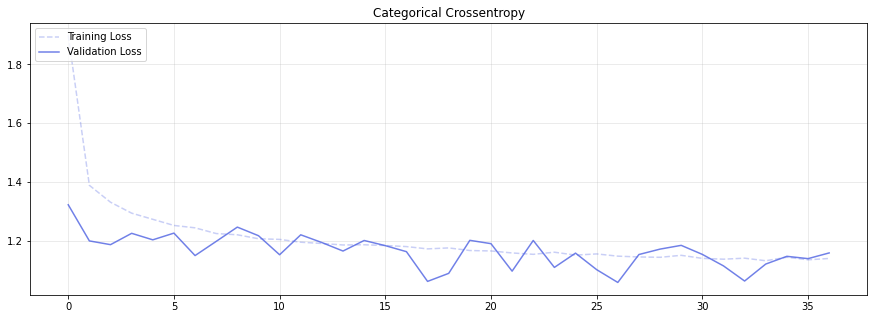

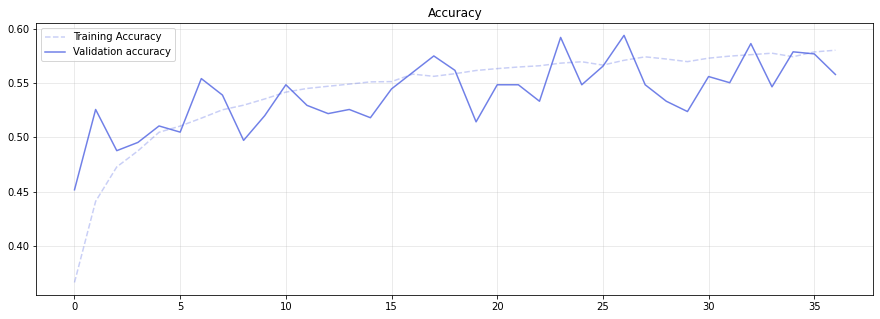

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
tl_model.save('Vgg16/model_cutout_2100_700_600')

In [17]:
tl_model = tfk.models.load_model('Vgg16/model_cutout_2100_700_600')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [18]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [19]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:13]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         

In [20]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [21]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
2482/2482 [==============================] - 510s 201ms/step - loss: 0.7832 - accuracy: 0.7239 - precision: 0.8353 - recall: 0.6191 - val_loss: 1.1244 - val_accuracy: 0.5939 - val_precision: 0.6915 - val_recall: 0.5104
Epoch 2/200
2482/2482 [==============================] - 351s 141ms/step - loss: 0.4066 - accuracy: 0.8644 - precision: 0.9135 - recall: 0.8213 - val_loss: 0.7941 - val_accuracy: 0.7799 - val_precision: 0.8150 - val_recall: 0.7438
Epoch 3/200
2482/2482 [==============================] - 353s 142ms/step - loss: 0.2745 - accuracy: 0.9134 - precision: 0.9422 - recall: 0.8878 - val_loss: 0.9942 - val_accuracy: 0.7647 - val_precision: 0.7798 - val_recall: 0.7457
Epoch 4/200
2482/2482 [==============================] - 339s 136ms/step - loss: 0.2080 - accuracy: 0.9349 - precision: 0.9530 - recall: 0.9183 - val_loss: 0.8081 - val_accuracy: 0.8349 - val_precision: 0.8456 - val_recall: 0.8311
Epoch 5/200
2482/2482 [==============================] - 340s 137ms/step - l

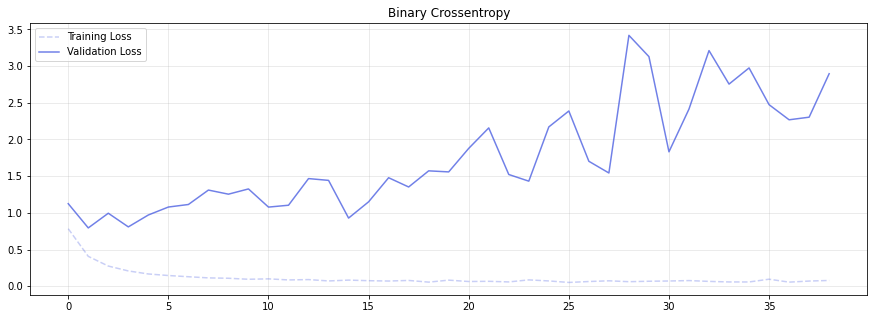

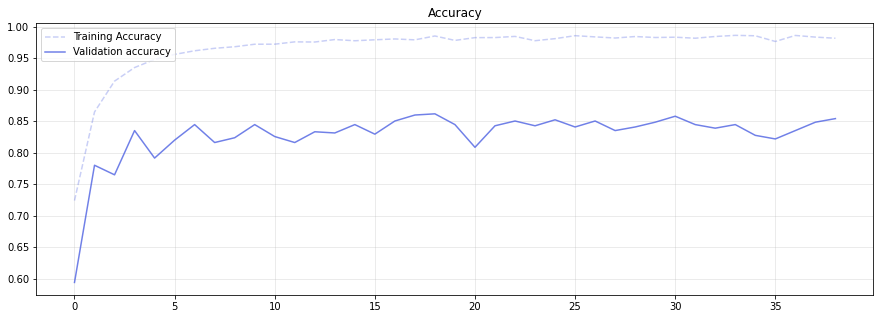

In [22]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [23]:
tl_model.save('Vgg16/Tuned_cutout_3400')

In [24]:
tl_model = tfk.models.load_model('Vgg16/Tuned_cutout_3400')

In [25]:
# Test the model
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 2s 99ms/step - loss: 2.1019 - accuracy: 0.8393 - precision: 0.8436 - recall: 0.8366

Test metrics
{'loss': 2.1018941402435303, 'accuracy': 0.8393352031707764, 'precision': 0.8435754179954529, 'recall': 0.8365650773048401}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.8393
Precision: 0.8149
Recall: 0.817
F1: 0.8143


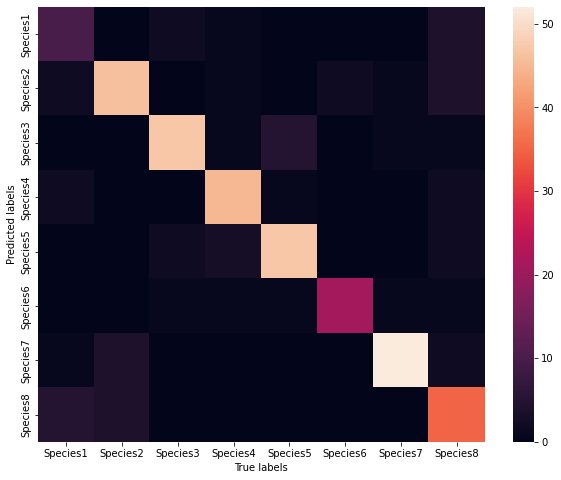

In [26]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()